# Brain Tumor Detection with SyMPC - [v2]
### Oleksandr Lytvyn
dataset: https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.utils import shuffle
from PIL import Image
import syft as sy
%matplotlib inline

device = torch.device('cpu')
# training on GPU in not awailable right now

torch.manual_seed(1)

In [2]:
from glob import glob
class BrainMRIDataset(Dataset):

    def __init__(self,data_dir,reshape=True,height=128,width=128, transform=None):
        self.dataDirectory = data_dir
        self.no_class = glob(data_dir+'/no/*')
        self.yes_class = glob(data_dir+'/yes/*')
        self.height = height
        self.width = width
        self.reshape=reshape
        self.transform = transform

        labels = [0 for i in range(len(self.no_class))]
        labels += [1 for i in range(len(self.yes_class))]

        image_links = self.no_class + self.yes_class
        self.dataframe = pd.DataFrame({
            'image':image_links,
            'labels': labels
        })

        self.dataframe = shuffle(self.dataframe)
        self.dataframe.reset_index(inplace=True,drop=True)

    def __len__(self):
        return len(self.no_class)+len(self.yes_class)

    def __getitem__(self,idx):

        image = self.dataframe['image'][idx]
        label = self.dataframe['labels'][idx]

        image = Image.open(image).convert("L")

        if self.reshape:
            image = image.resize((self.height,self.width))

        array = np.asarray(image)
        if self.transform:
            array = self.transform(array)
#             print(type(array))
        
        array = array.reshape(1, self.height,self.width)

#         print(type(array))
        image = torch.tensor(array)
        label = torch.tensor(label)

        return [image,label]

    def __repr__(self):
        return str(self.dataframe.head())


In [3]:
# transformations = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomChoice([
#         transforms.ColorJitter(brightness=1),
#         transforms.RandomRotation(degrees=45),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
#         transforms.RandomGrayscale(p=0.1)
#     ]),
#     transforms.ToTensor()
#     # transforms.Normalize(mean=[0.0,0.0,0.0], std=[1.0,1.0,1.0]) normalize images
# ])

# color_transformations = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomChoice([
#         transforms.ColorJitter(brightness=0.4),
#         transforms.ColorJitter(brightness=0.5),
#         transforms.ColorJitter(brightness=0.6),
#         transforms.ColorJitter(brightness=0.7)
#     ]),
#     transforms.ToTensor()
# ])

rotation_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomChoice([
        transforms.RandomRotation(degrees=30),
        transforms.RandomRotation(degrees=25),
        transforms.RandomRotation(degrees=20),
        transforms.RandomRotation(degrees=15)
    ]),
    transforms.ToTensor()
])

flip_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomChoice([
        transforms.RandomHorizontalFlip(p=1),
        transforms.RandomVerticalFlip(p=1),
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomVerticalFlip(p=1)
        ])
    ]),
    transforms.ToTensor()
])

grayscale_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomChoice([
        transforms.Grayscale(),
        transforms.RandomPerspective(distortion_scale=.1, p=1)
    ]),
    transforms.ToTensor()
])

In [4]:
#upload data
path_to_project_root = '../../../'
data_dir = path_to_project_root + 'data/brain_tumor_imgs'
dataset = BrainMRIDataset(data_dir, height=64, width=64, transform=None) + \
          BrainMRIDataset(data_dir, height=64, width=64, transform=rotation_transformations) + \
          BrainMRIDataset(data_dir, height=64, width=64, transform=flip_transformations)
#           BrainMRIDataset(data_dir, height=64, width=64, transform=grayscale_transformations)
print(dataset)

683, 76


<ipython-input-2-2e16d5b9921f>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


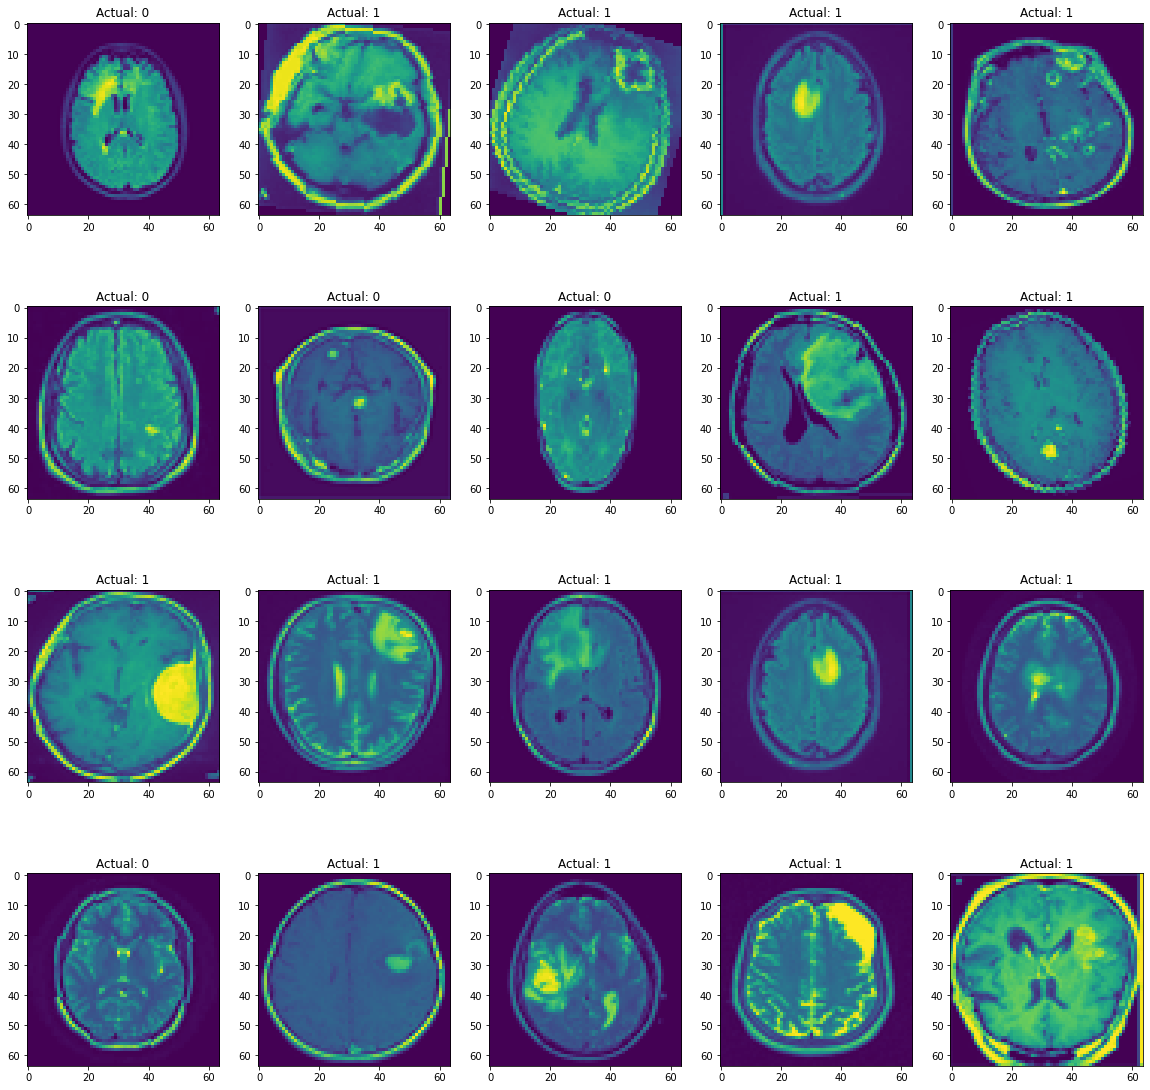

In [5]:
datasetsize = len(dataset)
train_size = int(datasetsize * 0.9)
test_size = datasetsize - train_size

train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])
print(f"{len(train_data)}, {len(test_data)}")


fig = plt.figure(figsize=(20,20))
for i in range(20):
    target = train_data[i][1]
    plt.subplot(4,5, i+1)
    plt.imshow(train_data[i][0][0])
    plt.title(f'Actual: {target}')
plt.show()


#### MODEL with SyMPC wraper

In [6]:
class BrainTumorModel(sy.Module):
    def __init__(self, torch_ref):
        super(BrainTumorModel, self).__init__(torch_ref=torch_ref)
        self.conv1 = self.torch_ref.nn.Conv2d(1, 128, kernel_size=3)
        self.conv2 = self.torch_ref.nn.Conv2d(128,32,kernel_size=2)
        self.linear1 = self.torch_ref.nn.Linear(30,64)
        self.linear2 = self.torch_ref.nn.Linear(64,32)
        self.flat = self.torch_ref.nn.Flatten(1)
        self.linear3 = self.torch_ref.nn.Linear(30720,2)

    def forward(self,x):
        x = self.conv1(x)
        print(x.shape)
        x = self.torch_ref.nn.functional.max_pool2d(x,2)
        print(x.shape)
        x = self.conv2(x)
        x = self.torch_ref.nn.functional.relu(x)
        print(x.shape)
        x = self.linear1(x)
        x = self.torch_ref.nn.functional.relu(x)
        print(x.shape)
        x = self.linear2(x)
        print(x.shape)
        x = self.flat(x)
        print(x.shape)
        x = self.linear3(x)
        print(x.shape)

        return x

In [8]:
model = BrainTumorModel(torch_ref=torch)
print(model)

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 201
plot = False

def test(model, test_loader, loss_fn):
    test_loss = 0
    accuracy = 0
    number_of_imags = len(test_loader)
    for image, label in test_loader:
        pred = model.forward(image.float())
        test_loss += loss_fn(pred, label).item()
        pred = torch.argmax(pred, dim=1)

        equality = (label.data == pred)
        accuracy += equality.type(torch.FloatTensor).mean()
        
    return test_loss/number_of_imags, accuracy/number_of_imags


def train(model, train_data, test_data, num_epochs = 100, batch_size = 32):
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)
    model.train()
    loss_list = []
    for epoch in range(num_epochs):
        total_loss = 0
        i=0
        for batch in train_loader:
            optimizer.zero_grad()
            image, label = batch
            images_batch = Variable(image)
            labels_batch = Variable(label)
            output = model(images_batch.float())
            loss = loss_fn(output, labels_batch)
            total_loss += loss
            loss.backward()
            optimizer.step()
            i+=1
            break
        if epoch%10 == 0:
            test_loss, accuracy = test(model, test_loader, loss_fn)
            print(f'Epochs: {epoch} Loss: {total_loss/i: .4f}, Accuracy: {accuracy: .4f}')
#             print('-----------------------------------------------')
        loss_list.append(total_loss/batch_size)
    return loss_list

In [10]:
loss_list_dumb = train(model, train_data, test_data, num_epochs=num_epochs)

<ipython-input-2-2e16d5b9921f>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


torch.Size([32, 128, 62, 62])
torch.Size([32, 128, 31, 31])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 2])
torch.Size([32, 128, 62, 62])
torch.Size([32, 128, 31, 31])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 2])
torch.Size([32, 128, 62, 62])
torch.Size([32, 128, 31, 31])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 2])
torch.Size([12, 128, 62, 62])
torch.Size([12, 128, 31, 31])
torch.Size([12, 32, 30, 30])
torch.Size([12, 32, 30, 64])
torch.Size([12, 32, 30, 32])
torch.Size([12, 30720])
torch.Size([12, 2])
Epochs: 0 Loss:  0.8012, Accuracy:  0.5486
torch.Size([32, 128, 62, 62])
torch.Size([32, 128, 31, 31])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 2])
to

torch.Size([32, 128, 62, 62])
torch.Size([32, 128, 31, 31])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 2])
torch.Size([32, 128, 62, 62])
torch.Size([32, 128, 31, 31])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 2])
torch.Size([32, 128, 62, 62])
torch.Size([32, 128, 31, 31])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 2])
torch.Size([32, 128, 62, 62])
torch.Size([32, 128, 31, 31])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 2])
torch.Size([32, 128, 62, 62])
torch.Size([32, 128, 31, 31])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 2])
torch.Size([32, 128, 62, 62])
torch.Size([32,

torch.Size([32, 128, 62, 62])
torch.Size([32, 128, 31, 31])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 2])
torch.Size([32, 128, 62, 62])
torch.Size([32, 128, 31, 31])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 2])
torch.Size([32, 128, 62, 62])
torch.Size([32, 128, 31, 31])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 2])
torch.Size([32, 128, 62, 62])
torch.Size([32, 128, 31, 31])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 2])
torch.Size([32, 128, 62, 62])
torch.Size([32, 128, 31, 31])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 2])
torch.Size([32, 128, 62, 62])
torch.Size([32,

torch.Size([32, 128, 62, 62])
torch.Size([32, 128, 31, 31])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 2])
torch.Size([32, 128, 62, 62])
torch.Size([32, 128, 31, 31])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 2])
torch.Size([32, 128, 62, 62])
torch.Size([32, 128, 31, 31])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 2])
torch.Size([32, 128, 62, 62])
torch.Size([32, 128, 31, 31])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 2])
torch.Size([12, 128, 62, 62])
torch.Size([12, 128, 31, 31])
torch.Size([12, 32, 30, 30])
torch.Size([12, 32, 30, 64])
torch.Size([12, 32, 30, 32])
torch.Size([12, 30720])
torch.Size([12, 2])
Epochs: 100 Loss:  0.4398, Accuracy:  0.7778


torch.Size([32, 128, 62, 62])
torch.Size([32, 128, 31, 31])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 2])
torch.Size([32, 128, 62, 62])
torch.Size([32, 128, 31, 31])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 2])
torch.Size([32, 128, 62, 62])
torch.Size([32, 128, 31, 31])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 2])
torch.Size([32, 128, 62, 62])
torch.Size([32, 128, 31, 31])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 2])
torch.Size([32, 128, 62, 62])
torch.Size([32, 128, 31, 31])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 2])
torch.Size([32, 128, 62, 62])
torch.Size([32,

torch.Size([32, 128, 62, 62])
torch.Size([32, 128, 31, 31])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 2])
torch.Size([32, 128, 62, 62])
torch.Size([32, 128, 31, 31])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 2])
torch.Size([32, 128, 62, 62])
torch.Size([32, 128, 31, 31])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 2])
torch.Size([32, 128, 62, 62])
torch.Size([32, 128, 31, 31])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 2])
torch.Size([32, 128, 62, 62])
torch.Size([32, 128, 31, 31])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 2])
torch.Size([32, 128, 62, 62])
torch.Size([32,

torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 2])
torch.Size([32, 128, 62, 62])
torch.Size([32, 128, 31, 31])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 2])
torch.Size([32, 128, 62, 62])
torch.Size([32, 128, 31, 31])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 2])
torch.Size([32, 128, 62, 62])
torch.Size([32, 128, 31, 31])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 2])
torch.Size([32, 128, 62, 62])
torch.Size([32, 128, 31, 31])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 2])
torch.Size([12, 128, 62, 62])
torch.Size([12, 128, 31, 31])
torch.Size([12, 32, 30, 30])
torch.Size([12, 

In [9]:
loss_list = train(model, train_data, test_data, num_epochs=num_epochs)

loss_list = [loss_item.detach() for loss_item in loss_list]

if plot:
    fig = plt.figure(figsize=(10,10))
    plt.plot(list(range(num_epochs)),loss_list)
    plt.title("Loss v/s Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

<ipython-input-2-2e16d5b9921f>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


Epochs: 0 Loss:  2.2363, Accuracy:  0.7014
Epochs: 10 Loss:  0.3429, Accuracy:  0.7708
Epochs: 20 Loss:  0.2512, Accuracy:  0.8611
Epochs: 30 Loss:  0.1397, Accuracy:  0.8125
Epochs: 40 Loss:  0.0769, Accuracy:  0.8403
Epochs: 50 Loss:  0.0546, Accuracy:  0.8889
Epochs: 60 Loss:  0.0318, Accuracy:  0.9097
Epochs: 70 Loss:  0.0239, Accuracy:  0.9271
Epochs: 80 Loss:  0.0103, Accuracy:  0.9097
Epochs: 90 Loss:  0.0129, Accuracy:  0.9097
Epochs: 100 Loss:  0.0245, Accuracy:  0.8993
Epochs: 110 Loss:  0.0112, Accuracy:  0.8993
Epochs: 120 Loss:  0.0266, Accuracy:  0.8993
Epochs: 130 Loss:  0.0143, Accuracy:  0.8715
Epochs: 140 Loss:  0.2639, Accuracy:  0.7049
Epochs: 150 Loss:  0.0850, Accuracy:  0.8403
Epochs: 160 Loss:  0.0312, Accuracy:  0.8889
Epochs: 170 Loss:  0.0240, Accuracy:  0.8403
Epochs: 180 Loss:  0.0483, Accuracy:  0.8299
Epochs: 190 Loss:  0.0162, Accuracy:  0.8507
Epochs: 200 Loss:  0.0150, Accuracy:  0.8368


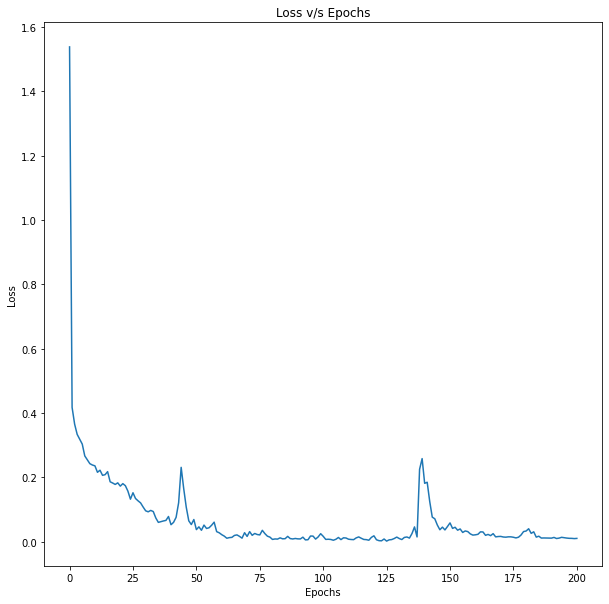

In [10]:
fig = plt.figure(figsize=(10,10))
plt.plot(list(range(num_epochs)),loss_list)
plt.title("Loss v/s Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [62]:
#Evaluate model

def test(model, test_loader, loss_fn):
    test_loss = 0
    accuracy = 0
    number_of_imags = len(test_loader)
    for image, label in test_loader:
        pred = model.forward(image.float())
        test_loss +=loss_fn(pred, label).item()
        pred = torch.argmax(pred, dim=1)

        equality = (label.data == pred)
        accuracy += equality.type(torch.FloatTensor).mean()
    print(f'Test Accuracy: {accuracy/number_of_imags:.2f} \n'
          f'Test Loss: {test_loss/len(image): .2f}')
    return test_loss, accuracy

test_loader = DataLoader(test_data, batch_size=1, shuffle=True)
test(model, test_loader, loss_fn)

<ipython-input-2-2e16d5b9921f>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


Test Accuracy: 0.97 
Test Loss:  15.42


(15.424643298758575, tensor(74.))

<ipython-input-2-2e16d5b9921f>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


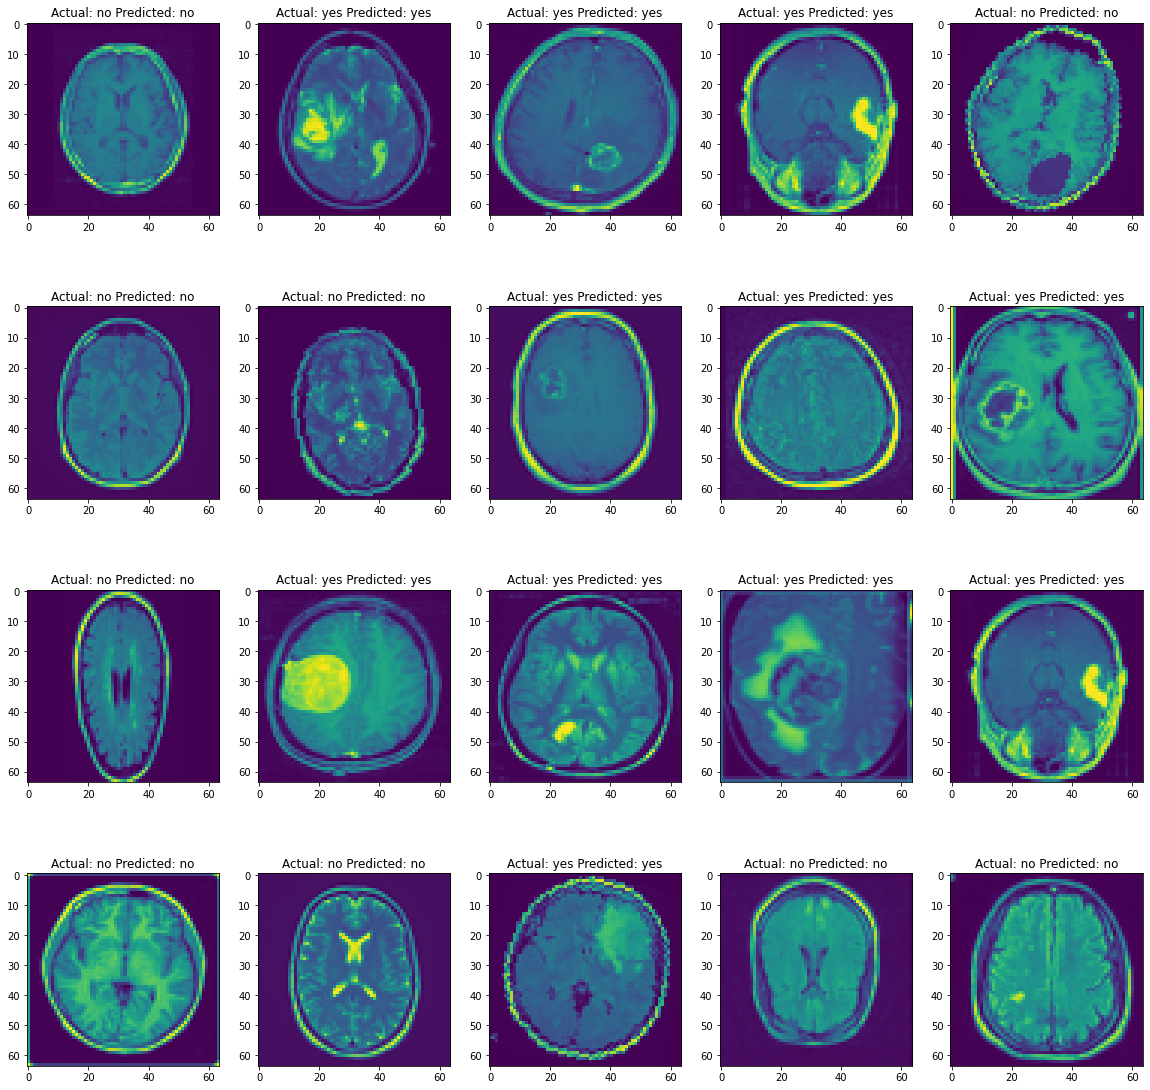

actual accuracy:  1.00


In [60]:
plot_loader = DataLoader(test_data, batch_size=1)

mapping = {0:'no',1:'yes'}
fig = plt.figure(figsize=(20,20))
i = 0
correct = 0
raw_predictions = []
for img, lbl in plot_loader:
    if i == 20: break
    pred = model(img.float())
#     print(pred)
    pred = torch.argmax(pred,dim=1)
    raw_predictions.append(pred)
    plt.subplot(4,5,i+1)
    plt.imshow(img[0][0].cpu())
    if lbl == pred: correct += 1
    plt.title(f'Actual: {mapping[lbl.cpu().detach().item()]} Predicted: {mapping[pred.cpu().detach().item()]}')
    i+=1
plt.show()
print(f"actual accuracy: {correct/i: .2f}")

In [13]:
raw_predictions

[tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([0]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([0]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([0]),
 tensor([0]),
 tensor([1]),
 tensor([1]),
 tensor([0]),
 tensor([1])]

### SyMPC part


In [43]:
import sympc
from sympc.session import Session
from sympc.session import SessionManager
from sympc.tensor import MPCTensor
from sympc.protocol import FSS
from sympc.protocol import Falcon

In [44]:
def get_clients(n_parties):
  #Generate required number of syft clients and return them.

  parties=[]
  for index in range(n_parties):
      parties.append(sy.VirtualMachine(name = "worker"+str(index)).get_root_client())

  return parties

def split_send(data,session):
    """Splits data into number of chunks equal to number of parties and distributes it to respective
       parties.
    """
    image_pointers = []

#     split_size = int(len(data)/len(session.parties))+1
    split_size = int(len(data)/len(session.parties))


    for index in range(0,len(session.parties)):
#         ptr=data[index*split_size:index*split_size+split_size].share(session=session)
        ptr=data[index*split_size:index*split_size+split_size]
        image_pointers.append(MPCTensor(secret=ptr, session=session))

    return image_pointers

In [49]:
#creating parties and session
parties = get_clients(2)
session = Session(parties=parties)
SessionManager.setup_mpc(session)


In [50]:
# default split data
ptrs = []
labels = []
for i, (img, lbl) in enumerate(plot_loader):
    if i == 20: break
    img_f = img.type(torch.float32)
    ptrs.append(MPCTensor(secret=img_f,session=session, requires_grad=True))
    labels.append(lbl)   
len(ptrs)



<ipython-input-2-2e16d5b9921f>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


20

In [51]:
mpc_model = model.share(session)
mpc_model

In [52]:
#Perform inference and measure time taken
import time
start_time = time.time()

results = []

for ptr in ptrs:
    encrypted_results = mpc_model(ptr)
    print(f"encrypted results: {encrypted_results}")
    plaintext_results = encrypted_results.reconstruct()
    print(f"plain text results: {plaintext_results}")
    results.append(plaintext_results)

end_time = time.time()
results

[2021-12-07T19:38:28.609018+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7ac7626833da4e9a8f4467b2c4e224ae>.
[2021-12-07T19:38:28.617280+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 55a93ebf64b84f9bba4d637f1fda6267>.
[2021-12-07T19:39:34.569968+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f3b556d1224a4f9788b60e53083b2a93>.
[2021-12-07T19:39:34.581632+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5b9f1a6ea51c48e4a89e94fd1726825e>.
[2021-12-07T19:40:08.090332+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8df9cddab505448c84d3cf9f22f7117f>.
[2021-12-07T19:40:08.093587+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bb81fa6231624f8e8d17f

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-648.8721,  608.2998]])


[2021-12-07T19:40:17.911856+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 70ee8ba52efc48bca14c0d50aaebfd63>.
[2021-12-07T19:40:17.918565+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4c50ae89644941e182441c5abab11990>.
[2021-12-07T19:40:17.937939+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 67b342565f3d46f6b0b3a41ac5205e08>.
[2021-12-07T19:40:17.945641+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e9592628eca44a3f9805596dcf97669c>.
[2021-12-07T19:40:17.950505+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dd6828e11c254a4aa58f2352a402618c>.
[2021-12-07T19:40:17.953031+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a23ac89b7018409eb93d6

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-10.7994,  11.4523]])


[2021-12-07T19:42:06.894981+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 94f4ea529afc404b853ff8c74da7f233>.
[2021-12-07T19:42:06.900085+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 65314f4a22604d3aa4ed2257772b2b99>.
[2021-12-07T19:42:06.913982+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 53745abeb2ed4f249b95df87494c6d71>.
[2021-12-07T19:42:06.922020+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e0016bbc14bb41099da247f011ddd204>.
[2021-12-07T19:43:12.636742+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2716ffa9a88c4d1d8d16573b5b537fd2>.
[2021-12-07T19:43:12.645239+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4356779db5bd4fb08f784

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-4.9413,  4.7105]])


[2021-12-07T19:43:53.891164+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: edbd57f84c9247f9ac7235d92cd1c496>.
[2021-12-07T19:43:53.900890+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7450d529196441d0b925f38eb6bfa70d>.
[2021-12-07T19:43:53.909260+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 69b7eaff72e04a7a9d005f810e2126c8>.
[2021-12-07T19:43:53.911848+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dc4a9e7181344c3cac1be2826775bc00>.
[2021-12-07T19:43:53.922036+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d863d4ec12a34b06bb75ea3adda72b37>.
[2021-12-07T19:43:53.924567+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4dbcdafd076d4c53a4fda

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.0944,  2.3544]])


[2021-12-07T19:45:47.264229+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c4b1f404739c439fb87932f56770686b>.
[2021-12-07T19:45:47.272078+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a7d74c638a72431f97e701bc0ec20318>.
[2021-12-07T19:45:47.289177+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9034601d2310419792d1a96921a30f94>.
[2021-12-07T19:45:47.294938+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9606f2f728444e6a8dfbfca75364df76>.
[2021-12-07T19:45:47.312010+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 704ce1e4678941b4997f2dbae989543d>.
[2021-12-07T19:45:47.314577+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f31a86a408774884a1e96

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.7068,  1.9366]])


[2021-12-07T19:47:36.129257+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ab007ed07c144c809de935da28bd5e7a>.
[2021-12-07T19:47:36.136887+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f283780b8b714a218b39b7ee5f0c0b95>.
[2021-12-07T19:47:36.151842+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d28db0910a49462380a61b7a1a3d9875>.
[2021-12-07T19:47:36.162161+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4fefd4b18016444db006ccabb06b869a>.
[2021-12-07T19:47:36.174351+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 214475df04cb4fa7bd015dda3b093d56>.
[2021-12-07T19:47:36.177516+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b3884c92fb0d4c1c95e6d

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.8294, -2.0651]])


[2021-12-07T19:49:27.181153+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9c19badb143245bc8b23812ca06bffec>.
[2021-12-07T19:49:27.187402+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6ee220336ce64854840dd78e5ff16206>.
[2021-12-07T19:49:27.211394+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 732e531bf79347c583e65299e01dbab5>.
[2021-12-07T19:49:27.214480+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3b4001fd08e64b95a8281524ea7b9e10>.
[2021-12-07T19:49:27.218557+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a3257796b57e411bb5f0390a3d5ffece>.
[2021-12-07T19:49:27.221244+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1cfae69b94df43e4b3c2b

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 3.2735, -3.4002]])


[2021-12-07T19:51:17.268525+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 772b12d9e1554336acc71bc7f2f46d7a>.
[2021-12-07T19:51:17.273725+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2242a9c89649478b984a7c3a1bbd08f5>.
[2021-12-07T19:51:17.283560+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 87166034cff74dd48c7c9699030d6d66>.
[2021-12-07T19:51:17.293557+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 53faaf167e5c42b2913eb5b8d9522e35>.
[2021-12-07T19:51:17.492638+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8d3c14c96cfd4001afbc4200c659464b>.
[2021-12-07T19:51:17.495180+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6867b4fd487347f987a5d

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1365.7144, -1350.5323]])


[2021-12-07T19:53:07.058039+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6c2033205050407aaddb0044dc755a22>.
[2021-12-07T19:53:07.066141+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ed48f470711e4eed85f621b49d515046>.
[2021-12-07T19:53:07.291406+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5505dcfae989462c87bf147ee76ffdab>.
[2021-12-07T19:53:07.294828+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0553159f2b8645279dbdd2aa7f5377fb>.
[2021-12-07T19:54:13.791241+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3ccb0b1eabb848a9a2e275f654c24d61>.
[2021-12-07T19:54:13.796407+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d05865cf6e9d426e82150

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 4540.5312, -4537.7974]])


[2021-12-07T19:54:55.508323+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 483f72ab3feb49ee8ed104f9f1facca6>.
[2021-12-07T19:54:55.515034+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 77a126dd561c41d6a01aea626ca2a7ee>.
[2021-12-07T19:54:55.530098+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 919e35789bec45439267919d49d10edc>.
[2021-12-07T19:54:55.533254+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ec914ae3c63446a3a696753a5ca20377>.
[2021-12-07T19:54:55.543815+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3aa8e0fda25048c29b52a13d28382272>.
[2021-12-07T19:54:55.546797+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 67110c8a5d6c4b26922f7

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.7881,  2.5544]])


[2021-12-07T19:56:47.207520+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a8f9e9a087fc4163b488136423599130>.
[2021-12-07T19:56:47.215869+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f96c0059d60543c88241ccfc6349ab24>.
[2021-12-07T19:56:47.241594+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 73d222dcd7a24ab4b9f397b02d425947>.
[2021-12-07T19:56:47.245657+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f13bc683d5cd48cdbb1933f141382312>.
[2021-12-07T19:56:47.254383+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f0f4e21e2d9e475eba34ec25a2795a3b>.
[2021-12-07T19:56:47.256832+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: aa71eab2e2324980a4176

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 6.0782, -5.8079]])


[2021-12-07T19:58:36.321180+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c862a548e4fa4e638ae69784a5100134>.
[2021-12-07T19:58:36.329914+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0872a4f8b58643caacc545ea80c7307d>.
[2021-12-07T19:58:36.355962+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9199c55c4d5840828f21a425fca38434>.
[2021-12-07T19:58:36.359193+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5432cc83870e491d927c02f660c50070>.
[2021-12-07T19:58:36.369115+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8c006fc6e6af4ef1848ce0dc87f57cb2>.
[2021-12-07T19:58:36.372289+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ffebb712fd7040228db68

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1676.0090, -1694.5839]])


[2021-12-07T20:00:29.565689+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e4db6150520c40c1b1d5005503fcc03f>.
[2021-12-07T20:00:29.572379+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e8c3db82a99e4d2bb87503747d220b03>.
[2021-12-07T20:00:29.599387+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 07517d20f0e6401497e41a6fa8094f76>.
[2021-12-07T20:00:29.602239+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 21620a833c9644acb2f658e2cdc6d25b>.
[2021-12-07T20:00:29.610781+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: db8d20a580e64a2f9e867378e0d9f967>.
[2021-12-07T20:00:29.613269+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5180c55db085477499b30

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1292.5032, -1402.2301]])


[2021-12-07T20:02:19.288079+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0eca8e335224483ca19338ec43631c21>.
[2021-12-07T20:02:19.295670+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 33ed6dcecf354431b642074b57f9f12d>.
[2021-12-07T20:02:19.316876+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8fcf6155b474436bae2331bf9843de71>.
[2021-12-07T20:02:19.319441+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c50433c4c76848ec9c181367de48f533>.
[2021-12-07T20:02:19.327554+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2b38d8f462924ad59df91c4c9781e627>.
[2021-12-07T20:02:19.329927+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 70921cb5be0a427dbb287

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-13.1297,  13.0769]])


[2021-12-07T20:04:11.709084+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6550f4c28abb4ef1945916d2f2d3cf46>.
[2021-12-07T20:04:11.722516+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2056a903db494029bd06f404181f800b>.
[2021-12-07T20:04:11.747076+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a2d6173c7ce04ac5855a274116e24514>.
[2021-12-07T20:04:11.749894+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c3fb26048edf462c938aadfc3feca215>.
[2021-12-07T20:04:11.756573+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7602010615ab4354b5acf157bfbf4f47>.
[2021-12-07T20:04:11.759205+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0c3409ae6d2f433380e0b

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.0719,  1.3474]])


[2021-12-07T20:06:02.390092+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 18dc0bb1c856470d99e94e2b7195ff9a>.
[2021-12-07T20:06:02.402864+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 71cdb97c0b1540d39cde01d0b23523a4>.
[2021-12-07T20:06:02.427140+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6d7a35946a7b4e76b0a0041294cbeb71>.
[2021-12-07T20:06:02.430081+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f3f3d219dc2044acb07b68c1c442920f>.
[2021-12-07T20:06:02.435500+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 070776980fcd44f88aff07d94ede2c12>.
[2021-12-07T20:06:02.438015+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8859d2ed147c409099c98

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 2283.8462, -2266.0762]])


[2021-12-07T20:07:52.871045+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6bc055dd18644dd481e63932f5de5e07>.
[2021-12-07T20:07:52.883701+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8693d9ec1826476d8b97c7b74fec3769>.
[2021-12-07T20:07:52.894535+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cf6b070b42f5470fa6b3ab3008525a01>.
[2021-12-07T20:07:52.897233+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a3786060d14c45b9881732c9ff8e275c>.
[2021-12-07T20:07:53.185128+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6224bce92b6c4dcf9e891c96a2a0de39>.
[2021-12-07T20:07:53.188159+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 19a362f83aec4b709030d

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-6.3830,  6.4485]])


[2021-12-07T20:09:44.159628+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7cb747bc18004c2fa7793954f8beb9c5>.
[2021-12-07T20:09:44.166872+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 74f1fba853444f7c932e50e6899d8170>.
[2021-12-07T20:09:44.179224+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: de69313df532483cbeab25e0b984452c>.
[2021-12-07T20:09:44.181699+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ea1be50abd2b4f048531795633ac4fb3>.
[2021-12-07T20:09:44.190457+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e0916d3441044a2a803da7bee9927714>.
[2021-12-07T20:09:44.192843+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c8481be4582c4a16923a1

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-14.5475,  14.6536]])


[2021-12-07T20:11:37.338543+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bbe123ffec124420a906f6180ebef4ac>.
[2021-12-07T20:11:37.345644+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b5b726edf168465daeefe20a192092d3>.
[2021-12-07T20:11:37.366939+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b41e90577f7048f5ad778625d1ae3a11>.
[2021-12-07T20:11:37.369771+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b95d6413abd04ce6b476d6ec1e346cf9>.
[2021-12-07T20:11:37.378098+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ace7dc5370904f99be4b08b0ebf7140e>.
[2021-12-07T20:11:37.380697+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d08a4453f3bb4526a56a5

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 15.1668, -15.1300]])


[2021-12-07T20:13:28.899884+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d64116c0531f447aa7dcca67a570e90c>.
[2021-12-07T20:13:28.906559+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7e303b4fcbd5487e8bf0a51bd812af9e>.
[2021-12-07T20:13:28.927796+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9c9d2a12d7a645aba97c1e22abf7110a>.
[2021-12-07T20:13:28.930501+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9d493ce675ac485dbc0dc64693eddc92>.
[2021-12-07T20:13:28.938737+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c8fe41530d7748de888f3a46fe7bb778>.
[2021-12-07T20:13:28.941085+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c4e358c3cd7d4081a349d

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 3.1614, -3.0454]])


[tensor([[-648.8721,  608.2998]]),
 tensor([[-10.7994,  11.4523]]),
 tensor([[-4.9413,  4.7105]]),
 tensor([[-2.0944,  2.3544]]),
 tensor([[-1.7068,  1.9366]]),
 tensor([[ 1.8294, -2.0651]]),
 tensor([[ 3.2735, -3.4002]]),
 tensor([[ 1365.7144, -1350.5323]]),
 tensor([[ 4540.5312, -4537.7974]]),
 tensor([[-2.7881,  2.5544]]),
 tensor([[ 6.0782, -5.8079]]),
 tensor([[ 1676.0090, -1694.5839]]),
 tensor([[ 1292.5032, -1402.2301]]),
 tensor([[-13.1297,  13.0769]]),
 tensor([[-1.0719,  1.3474]]),
 tensor([[ 2283.8462, -2266.0762]]),
 tensor([[-6.3830,  6.4485]]),
 tensor([[-14.5475,  14.6536]]),
 tensor([[ 15.1668, -15.1300]]),
 tensor([[ 3.1614, -3.0454]])]

<ipython-input-2-2e16d5b9921f>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


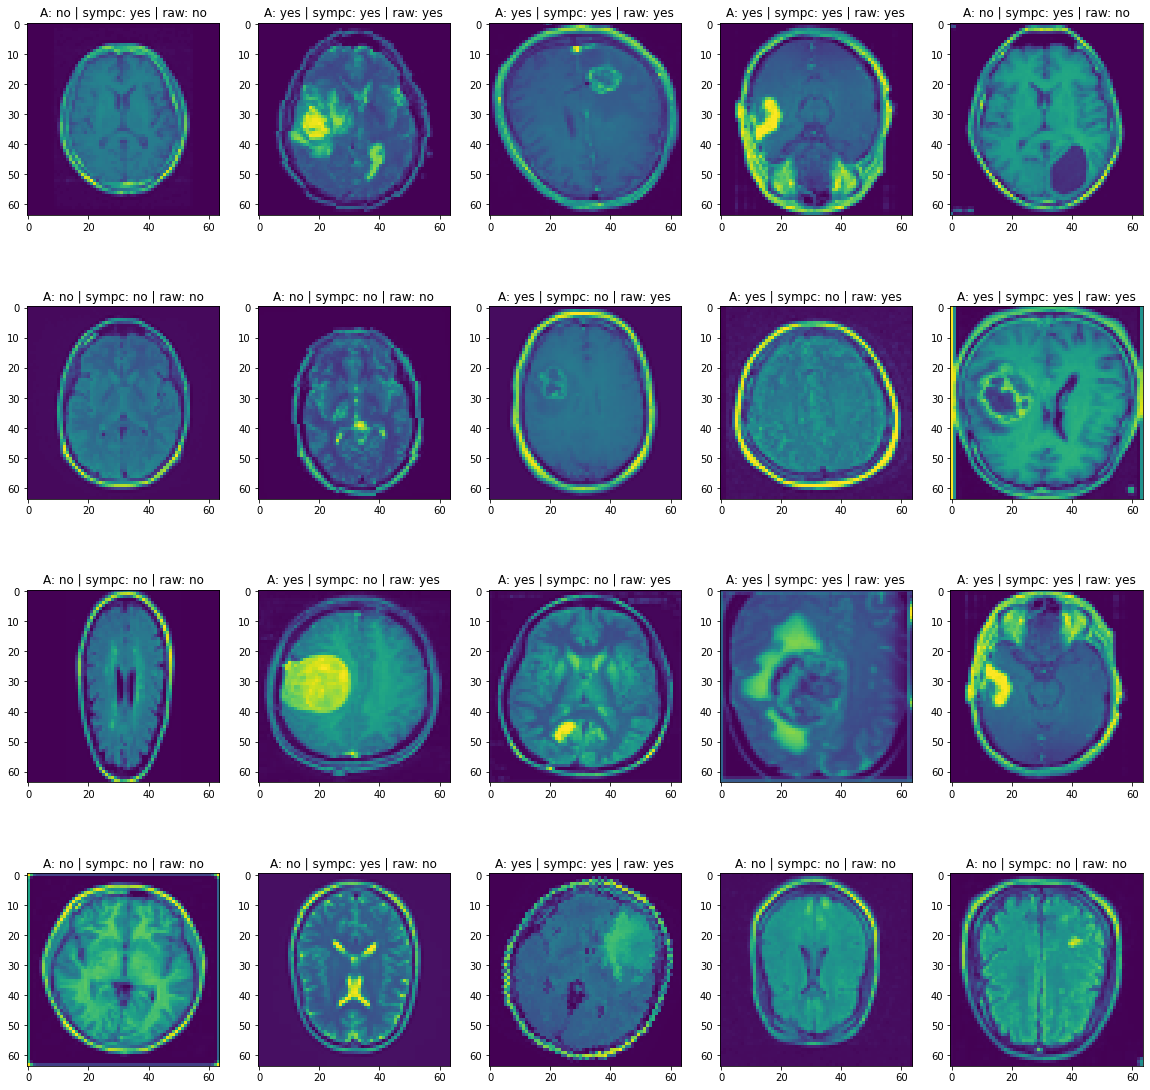

Time for inference: 2214.223940849304
Succes rate (sympc pred/actual labels):  0.68
Succes rate (sympc pred/raw pred):  0.68


In [57]:
fig = plt.figure(figsize=(20,20))
iter_loader = iter(plot_loader)
succes_sympc_overal = 0
succes_sympc_raw = 0
for i in range(20):
    img, label = next(iter_loader)
    pred = results[i]
    raw_pred = raw_predictions[i]
    target = labels[i]
    pred = torch.argmax(pred, dim=1)
    plt.subplot(4,5,i+1)
    plt.imshow(img[0][0])
    plt.title(f"A: {mapping[target.detach().item()]} | " +
              f"sympc: {mapping[pred.detach().item()]} | " +
              f"raw: {mapping[raw_pred.detach().item()]}")
    if pred == label: succes_sympc_overal += 1
    if pred == raw_pred: succes_sympc_raw += 1
    
plt.show()
print(f"Time for inference: {end_time - start_time}")
print(f"Succes rate (sympc pred/actual labels): {succes_sympc_overal/i: .2f}")
print(f"Succes rate (sympc pred/raw pred): {succes_sympc_raw/i: .2f}")

### advanced split data

In [26]:

imgs, lbls = next(iter(plot_loader))
data_to_split = []
for i, batch in enumerate(plot_loader):
    if i == 8: break
    img, lbl = batch
#     print(img)
    data_to_split.append(img)

print(len(data_to_split))


8


<ipython-input-2-2e16d5b9921f>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


In [64]:
a_ptrs = []
a_labels = []
for i, (img, lbl) in enumerate(plot_loader):
    img_f = img.type(torch.float32)
    a_ptrs.append(MPCTensor(secret=img_f,session=session, requires_grad=True))
    labels.append(lbl)   
len(a_ptrs)

<ipython-input-2-2e16d5b9921f>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


76

In [ ]:
import time
start_time = time.time()

a_results = []
a_encrypted_results =[]
i = 0
for ptr in a_ptrs:
    a_encrypted_result = mpc_model(ptr)
    print(f"encrypted results: {a_encrypted_results}")
#     a_plaintext_results = a_encrypted_results.reconstruct()
#     print(f"plain text results: {a_plaintext_results}")
#     a_results.append(a_plaintext_results)
    a_encrypted_results.append(a_encrypted_result)
    i+=1
    print(i)

end_time = time.time()
a_results

[2021-12-07T20:28:51.153785+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 480cee5808de410fa1939c93a3dc898c>.
[2021-12-07T20:28:51.161189+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c0750da1e057419baa90c31ebf618762>.
[2021-12-07T20:29:57.973091+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 57050a2850fc496f80e8f083fbbcb0d3>.
[2021-12-07T20:29:57.980058+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f69e2a80bac246d1bf82243f46531f8f>.
[2021-12-07T20:30:32.226423+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 58b180b63de74e7fb4648401addd388e>.
[2021-12-07T20:30:32.229663+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 79eb62aa4e0c44408bb66

encrypted results: []
1


[2021-12-07T20:30:41.921227+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 88809a2a257c49ab80b2ead32367fd92>.
[2021-12-07T20:30:41.927590+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 65648504576241c18b8d9579917077cf>.
[2021-12-07T20:30:42.230055+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ad52cdd9c4ce4fc090d6f664e8e241b8>.
[2021-12-07T20:30:42.236173+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7c2ce263868049d7867d18bd634dc989>.
[2021-12-07T20:31:49.590592+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e33de6391d9e46788d6aee8bd211c839>.
[2021-12-07T20:31:49.597773+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5e226e97d40e48bfb6668

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer]
2


[2021-12-07T20:32:32.493620+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cc057422efd14651ae5988472e67f4e5>.
[2021-12-07T20:32:32.499738+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 43adcf3d6b114ee7963ae289a8e0dae8>.
[2021-12-07T20:32:32.508981+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1d2fe9842d484b56ac6292502ec54d54>.
[2021-12-07T20:32:32.518213+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0013b7f9fe4d46fba953eeff9c0f945a>.
[2021-12-07T20:33:39.091193+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3e41af08d22d43dab492130daff81fd6>.
[2021-12-07T20:33:39.098017+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 42dc34a5ac0f44cdada2d

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer]
3


[2021-12-07T20:34:21.160353+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e23f6c10ae594259b03fd49283e9e127>.
[2021-12-07T20:34:21.169417+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 126843f2fc454e0dad5a29d4358e1630>.
[2021-12-07T20:34:21.182740+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 94a3696712044e5d99fd0395ae333c39>.
[2021-12-07T20:34:21.185532+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e8b23b6e3e10494b82fcd2a16c62f1b7>.
[2021-12-07T20:34:21.195273+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 97bec388893a462b90b948dc5d64d7be>.
[2021-12-07T20:34:21.198154+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: acd3f1a0d9084e70905e7

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer]
4


[2021-12-07T20:36:14.269272+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 825e1515fd9943189fc6789f50ae66c6>.
[2021-12-07T20:36:14.276136+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 79a0d583d7d94aacbdc3062c365e3a27>.
[2021-12-07T20:36:14.293954+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 64e0339df7644dfc8de2a67f89817820>.
[2021-12-07T20:36:14.299416+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d327c61d47bc4a919709db24712882b0>.
[2021-12-07T20:36:14.308340+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c6f48d5a7ee3491fbc2ae3f273941288>.
[2021-12-07T20:36:14.310852+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cd0ee9b42ff54fc0bbf4e

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer]
5


[2021-12-07T20:38:05.014875+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d8256981d20c432c82d53f4ac7e9cca4>.
[2021-12-07T20:38:05.022479+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0cd9c8c0c03e4844b430b1ba18137000>.
[2021-12-07T20:38:05.044226+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ff9131d8b6d14411bb212b3a23267f1d>.
[2021-12-07T20:38:05.047194+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c6088d96222e47ae892de87a31e0e618>.
[2021-12-07T20:38:05.056385+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bb5c2464dfc444cf90d0c805810cf371>.
[2021-12-07T20:38:05.058899+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 47494fc6e059475d9bf29

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer]
6


[2021-12-07T20:39:57.636349+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c97f0c56b5e94b7e81fb33e0c0421e1f>.
[2021-12-07T20:39:57.642248+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0b9f2ef6915046e3b3a9a344132aaac3>.
[2021-12-07T20:39:57.664985+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b6958ce369664721b7034a03d7e9e176>.
[2021-12-07T20:39:57.668232+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: eb43dcddf43f456d813f2b32b882fa2c>.
[2021-12-07T20:39:57.672834+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 20d014eca0594bc6a55eb28a83f65938>.
[2021-12-07T20:39:57.675522+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f302a06f3ad942058ac92

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Re

[2021-12-07T20:41:48.469825+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: efbb914005454253b48ae2517d9a50d5>.
[2021-12-07T20:41:48.481686+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 669cc42db9904ffca7ae70a6d6fead89>.
[2021-12-07T20:41:48.492030+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5d8801ba3ab244908c1a73b415f855ad>.
[2021-12-07T20:41:48.494704+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 21d901ae50c342cba74a3d3095317d54>.
[2021-12-07T20:41:48.767598+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9e71e6f019ef417980aea63665975c5d>.
[2021-12-07T20:41:48.770372+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7df88391be12467581387

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Re

[2021-12-07T20:43:40.725512+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 41c0c215ca2047ad9e1b6d31a19ac3c2>.
[2021-12-07T20:43:40.735695+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 32ed18c49b8e42ec8fd8b1cb32276fc4>.
[2021-12-07T20:43:40.750867+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 376f79ca37954cf7bf114c14313f0c0e>.
[2021-12-07T20:43:40.753770+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4c779c9f676e48558862804fda1066e6>.
[2021-12-07T20:44:47.858318+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a00e2cc468c349dab6434fd9ec2e042d>.
[2021-12-07T20:44:47.871270+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 46860e81bec84118b08c6

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Re

[2021-12-07T20:45:32.234758+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 481e68aa119e4be9b838584db04a1b4b>.
[2021-12-07T20:45:32.245723+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b0356828d7944f25b7493858019f50e6>.
[2021-12-07T20:45:32.600294+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0ea829b6b54945fa8e2c27be39272baa>.
[2021-12-07T20:45:32.603406+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 48bc627234f9484d974622d3c0ff46bf>.
[2021-12-07T20:46:38.486377+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 57c391ba32584798a4d5be76597a6ef1>.
[2021-12-07T20:46:38.494442+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 649581db9d064ff0a9a99

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Re

[2021-12-07T20:47:22.447144+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8956da1c08e9480a83fe1e712a1e44b4>.
[2021-12-07T20:47:22.455776+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3168abcf587d44b0a69b065919b45bce>.
[2021-12-07T20:48:29.552258+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 844fe4bd23454acd9ef863a8ed86a7e3>.
[2021-12-07T20:48:29.562994+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d4d4d3178aeb48eeb673cba6a21437a4>.
[2021-12-07T20:49:02.983252+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 02008c14b57e480990b80be342a8777a>.
[2021-12-07T20:49:02.986454+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5cb27f2e67a64bb383081

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Re

[2021-12-07T20:49:13.050071+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7941ea0c4bf049c4b6b30eacf7449e36>.
[2021-12-07T20:49:13.062480+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b0f77c33df9e48faaa83a67b3f9a0f54>.
[2021-12-07T20:49:13.083031+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 92cd5d491302446dad6dc1c53b0d7fce>.
[2021-12-07T20:49:13.086181+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b969ad233c764c54aa2aca028000d169>.
[2021-12-07T20:49:13.095578+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f39b6f88ca3042a5b73e89c202b2a2b1>.
[2021-12-07T20:49:13.098153+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 17176697a26d45faa9266

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Re

[2021-12-07T20:51:03.899739+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: edb8fa4e0fe04f25984e89ad618dc196>.
[2021-12-07T20:51:03.907115+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 040870423a3f4086a29cdcd8cb031f43>.
[2021-12-07T20:51:03.932071+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 09089a25016d4572a9d6b63446c8cdfb>.
[2021-12-07T20:51:03.935108+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 05f6ad6a58ae4821825e07266b13747c>.
[2021-12-07T20:51:03.944281+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0e033e7d69bc450cb1d4e95d1e5a58bd>.
[2021-12-07T20:51:03.946886+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0d653a1e89b84054b0239

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Re

[2021-12-07T20:52:57.314167+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4b361c3393b343b8887ed87940da581e>.
[2021-12-07T20:52:57.322639+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c61d67cfcecb4eeca70812ca12a53408>.
[2021-12-07T20:52:57.344474+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 49dbea691d3e46e7bd8169323ab349c0>.
[2021-12-07T20:52:57.347092+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4f19a0fefc1a4ce2927b95af62ec082a>.
[2021-12-07T20:52:57.355862+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7b53b9c36dfb409991fe2dc1237cf0b2>.
[2021-12-07T20:52:57.358397+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 02d99856d2694fcba7766

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Re

[2021-12-07T20:54:49.064126+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 77871adee3a141958514ce146adb274b>.
[2021-12-07T20:54:49.077647+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dfd77d35e3784921a006101d2e01b5b5>.
[2021-12-07T20:54:49.086348+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1d88b287a76046f98cded8535f28fbd0>.
[2021-12-07T20:54:49.089196+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 20545add8de74d3586eaad6fd6b064ae>.
[2021-12-07T20:55:57.858406+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 548748438f8e42a2a1d83ecbfbc4ee1f>.
[2021-12-07T20:55:57.866615+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 10527c64493d48dc98dae

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Re

[2021-12-07T20:56:42.348105+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: eee18c571fcd4198aa3aaf8292c1c146>.
[2021-12-07T20:56:42.363103+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2eb26740f3bd43cebb338ee26af3cac7>.
[2021-12-07T20:56:42.374802+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c37f80e020554b039e100757b126fcef>.
[2021-12-07T20:56:42.378208+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ec70e60b530f4e15a8dadb390212dfdc>.
[2021-12-07T20:57:51.447461+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 75a07eb517a843108d6cf866b62b4bfc>.
[2021-12-07T20:57:51.458206+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d90bbf2413d041e78b8d1

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Re

[2021-12-07T20:58:36.958871+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 783f726f8b314e57b72b7d3a6a761a1e>.
[2021-12-07T20:58:36.966541+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 24c8479cc2bc4630b15b67f6dcf25caa>.
[2021-12-07T20:58:37.297828+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 14fbe082f1dc461eb339304aadbabc85>.
[2021-12-07T20:58:37.300909+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a04fe14af8bb4f4b98498a2b48b62a9a>.
[2021-12-07T20:59:45.228336+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4e5a644a749e46268e4e1b19f410efd4>.
[2021-12-07T20:59:45.237961+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1038268b7b1f4ca68c2fe

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Re

[2021-12-07T21:00:29.451764+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 25b7278fb5bd444bb9bd6bcb64b9429a>.
[2021-12-07T21:00:29.459717+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 17ae65a449e048c3bb28e5157d434c3e>.
[2021-12-07T21:00:29.719024+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 717a6c76438e42e7b0521ace3804d1ba>.
[2021-12-07T21:00:29.721860+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 387c3046a193496e9ee6d330521539e8>.
[2021-12-07T21:01:36.879034+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e4e520fa275647c090a30b9120a78206>.
[2021-12-07T21:01:36.887530+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2b1dedafb20d462fa2138

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Re

[2021-12-07T21:02:19.670799+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5f2b77be64b145b98510e1942ecc58cf>.
[2021-12-07T21:02:19.682231+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7bc68028044a4040932b2e519ce8bca1>.
[2021-12-07T21:03:27.385269+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cd07e564d25e4206a14eb1a2a808f782>.
[2021-12-07T21:03:27.393212+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 23438f83145b4f708cc6c00f98adc2d3>.
[2021-12-07T21:04:02.033665+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d177e4399ef74b1f98cbfb2e9d4b974d>.
[2021-12-07T21:04:02.036919+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8cacea9e4e5e4d4d800f3

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Re

[2021-12-07T21:04:12.206581+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 777975556ab24bd394a51ec265d44739>.
[2021-12-07T21:04:12.217867+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fca975e7fb4a40fab546905f1f12f7f7>.
[2021-12-07T21:05:19.602902+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 74b4315830274d738426bfb92ec149ac>.
[2021-12-07T21:05:19.612712+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2bf0bdd08cc74a63814444183228e55e>.
[2021-12-07T21:05:53.738399+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 69d528c740b04787907fb330b33c0d7e>.
[2021-12-07T21:05:53.741797+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 97c60d59c4034e5083702

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Re

[2021-12-07T21:06:03.814345+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 81e32cd58608418ab44527de5239c787>.
[2021-12-07T21:06:03.822083+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1460f17f7f7443e7a733ef292794e063>.
[2021-12-07T21:07:11.774261+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4e46ad7ae3b347888d902115eab58392>.
[2021-12-07T21:07:11.783012+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c085efe183ec4eb6a6933ad37e0e5d58>.


In [ ]:
fig = plt.figure(figsize=(20,20))
for i in range(20):
    pred = results[i]
    target = labels[i]
    pred = torch.argmax(pred, dim=1)
    plt.subplot(4,5,i+1)
    plt.imshow(dataset[i][0][0][0])
    plt.title(f'Actual: {mapping[target.detach().item()]} Predicted: {mapping[pred.detach().item()]}')
plt.show()
print(f"Time for inference: {end_time - start_time}")



lxd tutorial 